# US News World Report Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

from IPython.display import Image
def draw(A):
    return Image(A.draw(format='png', prog='dot'))

In [4]:
import sys
from pathlib import Path
home = str(Path.home())

sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
sys.path.insert(0,"%s/RPLib"%home)
sys.path.insert(0,"%s/fairness_analysis"%home)

In [5]:
import pyrankability

In [6]:
import pyrplib

In [7]:
import equity_of_attention.common

In [75]:
years = list(range(2002,2003+1))
years

[2002, 2003]

In [76]:
data = {}
index = None
for year in years:
    data[year] = pd.read_excel('data/USNews liberal arts 2002-2016 (1).xls',sheet_name=str(year))
    data[year]['School Name'] = data[year]['School Name'].str.replace('!','')
    if 'State' in data[year].columns:
        data[year]['State'] = data[year]['State'].str.replace('\(','').str.replace('\)','')
    df = pd.DataFrame(list(data[year]['SAT/ACT 25th-75th Percentile'].str.split('-')),columns=['SAT/ACT 25th Percentile','SAT/ACT 75th Percentile'])
    data[year] = pd.concat([data[year],df],axis=1)
    data[year] = data[year].infer_objects()
    data[year]['SAT/ACT 25th-75th Percentile Mean'] = (data[year]['SAT/ACT 25th Percentile'].astype(int)+data[year]['SAT/ACT 75th Percentile'].astype(int))/2
    data[year] = data[year].set_index('School Name')
    if index is None:
        index = set(data[year].index)
    else:
        index = index.intersection(data[year].index)
colleges = list(index)
for year in years:
    data[year] = data[year].loc[colleges]

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [79]:
# Fix the order so that all the schools are the same order
data[2003]['Final Rank'].dtype

dtype('int64')

In [80]:
series_item_relevances = []
for year in years:
    order = np.argsort(data[year]['Final Rank'].values)
    data[year]['Final Rank Fixed'] = 0
    data[year].loc[:,'Final Rank Fixed'].iloc[order] = np.arange(1,len(order)+1)
    rank = np.array(list(data[year]['Final Rank Fixed'].values))
    ix = np.where(rank == 1)[0]
    print(data[year].index[ix])
    series_item_relevances.append((len(colleges) - rank+1)/len(colleges))

Index(['Amherst College'], dtype='object', name='School Name')
Index(['Amherst College'], dtype='object', name='School Name')


In [81]:
series_item_relevances_df = pd.DataFrame(series_item_relevances,columns=colleges,index=years).T.dropna()
series_item_relevances_df

,2002,2003
Wellesley College,0.94,0.94
Bowdoin College,0.92,0.86
Franklin and Marshall College,0.28,0.28
Colgate University,0.66,0.62
Oberlin College,0.58,0.56
Bard College,0.24,0.30
Swarthmore College,0.98,0.96
DePauw University,0.20,0.24
Connecticut College,0.50,0.34
Occidental College,0.10,0.10


I want to see if any team moves outside the top 10

In [82]:
n = 10
(-1*series_item_relevances_df.iloc[:,0]).sort_values()[:n].index

Index(['Amherst College', 'Swarthmore College', 'Williams College',
       'Wellesley College', 'Bowdoin College', 'Pomona College',
       'Haverford College', 'Carleton College', 'Middlebury College',
       'Davidson College'],
      dtype='object')

In [83]:
(-1*series_item_relevances_df.iloc[:,1]).sort_values()[:n].index

Index(['Amherst College', 'Williams College', 'Swarthmore College',
       'Wellesley College', 'Carleton College', 'Pomona College',
       'Middlebury College', 'Bowdoin College', 'Davidson College',
       'Haverford College'],
      dtype='object')

In [84]:
s1 = set((-1*series_item_relevances_df.iloc[:,0]).sort_values()[:n].index)
s2 = set((-1*series_item_relevances_df.iloc[:,1]).sort_values()[:n].index)
#s3 = set((-1*series_item_relevances_df.iloc[:,2]).sort_values()[:n].index)
len(s1.intersection(s2))#.intersection(s3))

10

In [85]:
len(s1.union(s2).union(s3))

10

In [86]:
def solutions2rankings(solutions,colleges):
    rankings = []
    for i in range(len(solutions)):
        rankings.append(pd.DataFrame(solutions[i],index=colleges).apply(lambda x: np.where(x == 1)[0][0],axis=1))
    return rankings

In [87]:
series_item_relevances[0]

array([0.94, 0.92, 0.28, 0.66, 0.58, 0.24, 0.98, 0.2 , 0.5 , 0.1 , 0.56,
       0.78, 0.54, 0.74, 0.68, 0.22, 0.04, 0.38, 0.02, 0.62, 0.82, 0.86,
       0.12, 0.4 , 0.44, 0.72, 0.3 , 0.14, 0.06, 0.52, 0.76, 0.46, 0.26,
       0.88, 0.7 , 0.6 , 0.34, 0.9 , 0.96, 0.08, 0.32, 0.16, 0.84, 0.64,
       0.8 , 0.18, 0.48, 0.36, 0.42, 1.  ])

In [88]:
single_solutions = []
single_baseline_unfairness = []
single_unfairness = []
single_rankings = []
for i in range(len(series_item_relevances)):
    solutions, baseline_unfairness, unfairness = equity_of_attention.common.model_3([series_item_relevances[i]],item_names=colleges)
    single_solutions.append(solutions)
    single_baseline_unfairness.append(baseline_unfairness)
    single_unfairness.append(unfairness)
    single_rankings.append(solutions2rankings(solutions,colleges))

In [89]:
for i in range(len(series_item_relevances)):
    rankings = solutions2rankings(single_solutions[i],colleges)
    display(rankings[0])

Wellesley College                 3
Bowdoin College                   4
Franklin and Marshall College    43
Colgate University               37
Oberlin College                  31
Bard College                     25
Swarthmore College                1
DePauw University                17
Connecticut College              12
Occidental College               49
Bates College                    48
Grinnell College                 47
Mount Holyoke College            46
Vassar College                   45
Bryn Mawr College                44
Sarah Lawrence College           42
Wabash College                   41
College of the Holy Cross        40
Gettysburg College               39
Hamilton College                 38
Davidson College                  9
Carleton College                  7
Rhodes College                   36
Barnard College                  35
University of the South          34
Smith College                    33
Union College                    32
Furman University           

Wellesley College                 3
Bowdoin College                   7
Franklin and Marshall College    17
Colgate University               41
Oberlin College                  37
Bard College                     29
Swarthmore College                2
DePauw University                19
Connecticut College              12
Occidental College               49
Bates College                    48
Grinnell College                 47
Mount Holyoke College            46
Vassar College                   45
Bryn Mawr College                44
Sarah Lawrence College           43
Wabash College                   42
College of the Holy Cross        40
Gettysburg College               39
Hamilton College                 38
Davidson College                  8
Carleton College                  4
Rhodes College                   36
Barnard College                  35
University of the South          34
Smith College                    33
Union College                    32
Furman University           

In [121]:
solutions, baseline_unfairness, unfairness = equity_of_attention.common.model_3(series_item_relevances)

In [122]:
unfairness

[24.500976562500004, 49.001953125]

In [123]:
rankings = solutions2rankings(solutions,colleges)

In [124]:
k = 20
top_k = []
for i in range(len(rankings)):
    top_k.append(list(rankings[i].sort_values()[:k].index))
top_k_df = pd.DataFrame(top_k,index=years).T
top_k_df

,2002,2003
0,Amherst College,Amherst College
1,Swarthmore College,Williams College
2,Williams College,Swarthmore College
3,Wellesley College,Wellesley College
4,Bowdoin College,Carleton College
5,Pomona College,Pomona College
6,Haverford College,Middlebury College
7,Carleton College,Bowdoin College
8,Middlebury College,Davidson College
9,Davidson College,Haverford College


In [125]:
colleges_of_interest = np.unique(top_k_df)

In [126]:
data_for_D = []
for year in years:
    data_for_D.append(list(data[year]['Final Rank Fixed'].values))
data_for_D = pd.DataFrame(data_for_D,columns=colleges,index=years).T
data_for_D = data_for_D.loc[colleges_of_interest]
data_for_D

,2002,2003
Amherst College,1,1
Bowdoin College,5,8
Bucknell University,30,33
Carleton College,8,5
Centre College,43,45
Claremont McKenna College,19,13
Connecticut College,26,34
Davidson College,10,9
DePauw University,41,39
Franklin and Marshall College,37,37


In [127]:
trans = pyrplib.transformers.ColumnCountTransformer(data_for_D.columns[:2])
trans.fit(data_for_D)
D = trans.transform(data_for_D)
D

,Amherst College,Bowdoin College,Bucknell University,Carleton College,Centre College,Claremont McKenna College,Connecticut College,Davidson College,DePauw University,Franklin and Marshall College,...,Lafayette College,Macalester College,Middlebury College,Pomona College,Scripps College,Skidmore College,Swarthmore College,Wellesley College,Wesleyan University,Williams College
None1,,,,,,,,,,,,,,,,,,,,,
Amherst College,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Bowdoin College,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0
Bucknell University,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
Carleton College,0.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0
Centre College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Claremont McKenna College,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,...,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
Connecticut College,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,...,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
Davidson College,0.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,...,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0
DePauw University,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [128]:
delta_cont, details_cont = pyrankability.rank.solve(D,method='lop',cont=True)
delta_bin, details_bin = pyrankability.rank.solve(D,method='lop',cont=False)

In [129]:
perm = list(details_bin['P'][0])
D.columns[perm]

Index(['Amherst College', 'Williams College', 'Swarthmore College',
       'Wellesley College', 'Pomona College', 'Carleton College',
       'Middlebury College', 'Bowdoin College', 'Haverford College',
       'Davidson College', 'Wesleyan University', 'Claremont McKenna College',
       'Macalester College', 'Scripps College', 'Lafayette College',
       'Connecticut College', 'Bucknell University',
       'Franklin and Marshall College', 'DePauw University',
       'Skidmore College', 'Centre College'],
      dtype='object')

In [130]:
xstar = pd.DataFrame(details_cont['x'],index=D.index,columns=D.columns)
xstars = {}
xstars["Final Rank Driven"] = xstar
g,_,_ = pyrankability.plot.show_score_xstar2(xstars,group_label="Group",width=500,height=500,columns=1,resolve_scale=True)
g

alt.FacetChart(...)

In [131]:
def perm_to_series(D,perm,name):
    return pd.Series(list(D.index[list(perm)]),name=name)
obj, farthest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=False)

In [146]:
position_attentions = equity_of_attention.common.calc_position_attentions(len(lop_ranking_x))
position_attentions

array([0.5       , 0.25      , 0.125     , 0.0625    , 0.03125   ,
       0.015625  , 0.0078125 , 0.00390625, 0.00195312, 0.00097656,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [154]:
np.array(farthest_pair_details['perm_x'])

array([ 0, 20, 17, 18,  3, 14, 13,  1,  7, 10, 19,  5,  6, 12, 11, 15,  2,
        9,  8, 16,  4])

### Unfairness of LOP

In [175]:
acc_attentions = position_attentions[np.array(farthest_pair_details['perm_x'])] + position_attentions[np.array(farthest_pair_details['perm_y'])]
acc_attentions

array([1.        , 0.        , 0.        , 0.        , 0.3125    ,
       0.        , 0.        , 0.3125    , 0.00390625, 0.00390625,
       0.        , 0.03125   , 0.0078125 , 0.125     , 0.        ,
       0.        , 0.1328125 , 0.00195312, 0.00390625, 0.        ,
       0.0625    ])

In [176]:
pd.Series(acc_attentions)

0     1.000000
1     0.000000
2     0.000000
3     0.000000
4     0.312500
5     0.000000
6     0.000000
7     0.312500
8     0.003906
9     0.003906
10    0.000000
11    0.031250
12    0.007812
13    0.125000
14    0.000000
15    0.000000
16    0.132812
17    0.001953
18    0.003906
19    0.000000
20    0.062500
dtype: float64

In [177]:
acc_relevances = pd.Series(series_item_relevances[0],index=colleges).loc[colleges_of_interest] + pd.Series(series_item_relevances[1],index=colleges).loc[colleges_of_interest]
acc_relevances

Amherst College                  2.00
Bowdoin College                  1.78
Bucknell University              0.78
Carleton College                 1.78
Centre College                   0.28
Claremont McKenna College        1.40
Connecticut College              0.84
Davidson College                 1.66
DePauw University                0.44
Franklin and Marshall College    0.56
Haverford College                1.70
Lafayette College                0.78
Macalester College               0.98
Middlebury College               1.72
Pomona College                   1.80
Scripps College                  0.76
Skidmore College                 0.36
Swarthmore College               1.94
Wellesley College                1.88
Wesleyan University              1.60
Williams College                 1.94
dtype: float64

In [179]:
unfairness_lop = np.sum(np.abs(acc_attentions - acc_relevances))
unfairness_lop

25.046953125000005

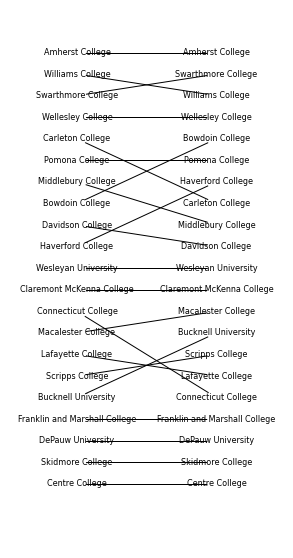

In [132]:
A = perm_to_series(D,farthest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_fairness.png')

In [180]:
new_rankings = []
new_perms = []
for i in range(len(rankings)):
    new_rankings.append(rankings[i].loc[colleges_of_interest].copy())
    order = np.argsort(rankings[i].loc[colleges_of_interest].values)
    new_rankings[i][order] = np.arange(0,len(order))
    new_perms.append(np.argsort(new_rankings[i]))

In [182]:
new_rankings[i]

Amherst College                   0
Bowdoin College                   7
Bucknell University              10
Carleton College                  4
Centre College                   18
Claremont McKenna College        16
Connecticut College              12
Davidson College                  8
DePauw University                19
Franklin and Marshall College    17
Haverford College                 9
Lafayette College                11
Macalester College               13
Middlebury College                6
Pomona College                    5
Scripps College                  20
Skidmore College                 14
Swarthmore College                2
Wellesley College                 3
Wesleyan University              15
Williams College                  1
dtype: int64

In [184]:
acc_attentions = position_attentions[np.array(new_perms[0])] + position_attentions[np.array(new_perms[1])]
acc_attentions

array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.1250000e-01, 0.0000000e+00, 0.0000000e+00, 3.1250000e-01,
       3.9062500e-03, 3.9062500e-03, 2.5000000e-01, 0.0000000e+00,
       1.5625000e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.1250000e-02, 2.9296875e-03, 6.2500000e-02, 1.9531250e-03,
       9.7656250e-04])

In [186]:
pd.Series(acc_attentions)

0     1.000000
1     0.000000
2     0.000000
3     0.000000
4     0.312500
5     0.000000
6     0.000000
7     0.312500
8     0.003906
9     0.003906
10    0.250000
11    0.000000
12    0.015625
13    0.000000
14    0.000000
15    0.000000
16    0.031250
17    0.002930
18    0.062500
19    0.001953
20    0.000977
dtype: float64

In [187]:
acc_relevances = pd.Series(series_item_relevances[0],index=colleges).loc[colleges_of_interest] + pd.Series(series_item_relevances[1],index=colleges).loc[colleges_of_interest]
acc_relevances

Amherst College                  2.00
Bowdoin College                  1.78
Bucknell University              0.78
Carleton College                 1.78
Centre College                   0.28
Claremont McKenna College        1.40
Connecticut College              0.84
Davidson College                 1.66
DePauw University                0.44
Franklin and Marshall College    0.56
Haverford College                1.70
Lafayette College                0.78
Macalester College               0.98
Middlebury College               1.72
Pomona College                   1.80
Scripps College                  0.76
Skidmore College                 0.36
Swarthmore College               1.94
Wellesley College                1.88
Wesleyan University              1.60
Williams College                 1.94
dtype: float64

In [188]:
unfairness_equity = np.sum(np.abs(acc_attentions - acc_relevances))
unfairness_equity

25.046953125000005

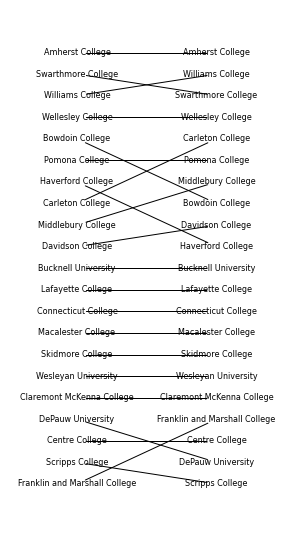

In [143]:
A = perm_to_series(D,new_perms[0],'ranking_perm0')
B = perm_to_series(D,new_perms[1],'ranking_perm1')
pyrankability.plot.spider2(A,B,file=f'results/equity_pair_fairness.png')